### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from os import walk

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from scipy import stats

#### Load all sheets in the underlying file

In [2]:
file_path = '../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

file_list = []
for (dirpath, dirnames, filenames) in walk(file_path):
    file_list.extend(filenames)
    break

file_list = [x for x in file_list if x[-3:] == 'csv']

In [3]:
##sheet = client.open('Learning Log').sheet1
raw_df = pd.DataFrame()
for file_name in file_list:
    sub_table = pd.read_csv(file_path + file_name)
    sub_table['sheet_name'] = file_name.split('.')[0]
    raw_df = pd.concat([raw_df, sub_table], sort=True)

raw_df.tail()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,sheet_name
250,0.0,Australia,0.0,2020-03-06T04:33:03,-12.4634,130.8456,Northern Territory,0.0,03-08-2020
251,0.0,US,0.0,2020-02-24T23:33:02,29.3829,-98.6134,"Lackland, TX (From Diamond Princess)",0.0,03-08-2020
252,0.0,US,0.0,2020-03-07T19:53:02,30.3213,-95.4778,"Montgomery County, TX",0.0,03-08-2020
253,0.0,US,0.0,2020-02-24T23:33:02,41.2545,-95.9758,"Omaha, NE (From Diamond Princess)",0.0,03-08-2020
254,0.0,US,0.0,2020-02-24T23:33:02,38.2721,-121.9399,"Travis, CA (From Diamond Princess)",0.0,03-08-2020


In [4]:
raw_df['Last Update'].max()

'2020-03-13T23:13:12'

In [5]:
# Merge duplicate columns with different names
main_df = raw_df

# main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

# main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

# main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']
main_df.loc[main_df['Province/State']=='None', 'Province/State'] = main_df.loc[main_df['Province/State']=='None', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update', '',
                                                'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'
                                                'Announcement'])]

## main_df = main_df.drop(columns=['Announcement',
                      ## 'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])

main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,sheet_name
159,2.0,US,0.0,2020-03-08T21:43:03,36.0796,-115.0940,"Clark County, NV",0.0,03-08-2020
4,1001.0,Mainland China,2.0,2020-02-15T13:03:04,NaN,NaN,Hunan,425.0,02-15-2020
2,1006.0,Mainland China,0.0,2020-02-07T11:33:11,NaN,NaN,Zhejiang,123.0,02-07-2020
32,1.0,China,0.0,2020-03-11T02:18:14,31.6927,88.0924,Tibet,1.0,03-13-2020
50,3.0,Philippines,1.0,2020-02-12T07:43:02,NaN,NaN,Philippines,1.0,02-17-2020


In [6]:
main_df.sheet_name.str.split('-')

0      [02, 26, 2020]
1      [02, 26, 2020]
2      [02, 26, 2020]
3      [02, 26, 2020]
4      [02, 26, 2020]
            ...      
250    [03, 08, 2020]
251    [03, 08, 2020]
252    [03, 08, 2020]
253    [03, 08, 2020]
254    [03, 08, 2020]
Name: sheet_name, Length: 5383, dtype: object

In [7]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Taipei and environs','Taiwan')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Taiwan\*','Taiwan')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United Kingdom','UK')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'Viet Nam','Vietnam')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('-').apply(lambda x: x[0])
main_df['day'] = main_df.sheet_name.str.split('-').apply(lambda x: x[1])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
# main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau', 'Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong', 'Country/Region'] = 'Hong Kong'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

In [8]:
main_df.describe(include=np.object)

,Country/Region,Province/State,sheet_name,month,day
count,5383,5383,5383,5383,5383
unique,147,390,52,3,31
top,Mainland China,Hebei,03-09-2020,03,09
freq,1610,54,266,2565,338


In [9]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  ## 'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period
0,Azerbaijan,Azerbaijan,02,28,2020-02-28 13:03:26,1.0,0.0,0.0,2020-02-28
1,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24
2,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25
3,Afghanistan,Afghanistan,02,26,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-26
4,Afghanistan,Afghanistan,02,27,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-27
...,...,...,...,...,...,...,...,...,...
5374,Vietnam,Vietnam,03,12,2020-03-12 07:33:03,39.0,16.0,0.0,2020-03-12
5375,Vietnam,Vietnam,03,13,2020-03-11 18:00:00,47.0,16.0,0.0,2020-03-13
5376,occupied Palestinian territory,occupied Palestinian territory,03,10,2020-03-10 17:13:21,25.0,0.0,0.0,2020-03-10
5377,occupied Palestinian territory,occupied Palestinian territory,03,11,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-11


#### Some baisc checks

2020-01-22 15:00:00    38
2020-01-23 15:00:00    46
2020-01-24 15:00:00    41
2020-01-25 15:00:00    44
2020-01-26 14:00:00    47
                       ..
2020-03-12 21:44:32     3
2020-03-12 21:44:33    13
2020-03-13 09:09:03    15
2020-03-13 11:33:03     1
2020-03-13 21:13:12     1
Name: Last Update, Length: 1393, dtype: int64

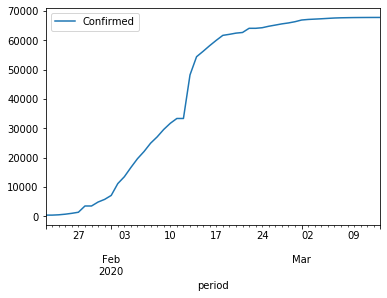

In [10]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [11]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Iran (Islamic Republic of)    1
Republic of Moldova           1
Ashland, NE                   1
Cherokee County, GA           1
Antigua and Barbuda           1
Lackland, TX                  1
Viet Nam                      1
Guinea                        1
United Kingdom                1
 Azerbaijan                   1
Jefferson Parish, LA          1
Charlotte County, FL          1
Spartanburg County, SC        1
Kazakhstan                    1
Johnson County, IA            1
Manitoba                      1
Ivory Coast                   1
North Ireland                 1
Cayman Islands                1
Kenya                         1
Name: Province/State, dtype: int64

In [12]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Iran (Islamic Republic of)', 'Republic of Moldova', 'Ashland, NE',
       'Cherokee County, GA', 'Antigua and Barbuda', 'Lackland, TX',
       'Viet Nam', 'Guinea', 'United Kingdom', ' Azerbaijan'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

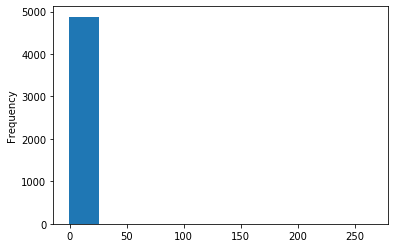

In [13]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

#### Drop province/state with multiple regions

In [14]:
state_count = clean_df.groupby('Province/State')['Country/Region'].nunique().sort_values(ascending=False).reset_index()
state_count
clean_state = state_count.loc[state_count['Country/Region']==1,'Province/State'].to_list()
clean_df = clean_df[clean_df['Province/State'].isin(clean_state)]

In [15]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
156,Australia,Northern Territory,03,06,2020-03-06 02:33:03,0.0,0.0,0.0,2020-03-06,1.0,-1.0,-1.000000
165,Australia,Queensland,01,31,2020-01-31 21:59:00,2.0,0.0,0.0,2020-01-31,3.0,-1.0,-0.333333
167,Australia,Queensland,02,02,2020-02-02 20:33:07,2.0,0.0,0.0,2020-02-02,3.0,-1.0,-0.333333
372,Bahrain,Bahrain,03,13,2020-03-11 18:00:00,189.0,44.0,0.0,2020-03-13,195.0,-6.0,-0.030769
1343,Japan,Japan,01,23,2020-01-23 15:00:00,1.0,0.0,0.0,2020-01-23,2.0,-1.0,-0.500000
1358,Japan,Japan,02,07,2020-02-07 02:13:20,25.0,1.0,0.0,2020-02-07,45.0,-20.0,-0.444444
3458,Others,Diamond Princess cruise ship,03,06,2020-03-05 23:29:39,696.0,40.0,6.0,2020-03-06,706.0,-10.0,-0.014164
4359,US,"Fairfield County, CT",03,08,2020-03-08 19:23:03,1.0,0.0,0.0,2020-03-08,2.0,-1.0,-0.500000
4515,US,"Lackland, TX (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,2.0,-2.0,-1.000000
4705,US,"New York County, NY",03,07,2020-03-07 16:23:05,11.0,0.0,0.0,2020-03-07,16.0,-5.0,-0.312500


In [16]:
# focus on cases where base is above 20
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 30]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000,1859.000000
mean,1653.272727,604.034965,52.044110,1578.747714,74.525013,0.104985,19.103281
std,8314.413598,3895.013519,328.465598,8160.248352,477.016008,0.206363,13.656405
min,25.000000,0.000000,0.000000,30.000000,-20.000000,-0.444444,1.000000
25%,89.000000,7.000000,0.000000,76.000000,0.000000,0.000000,7.000000
50%,195.000000,51.000000,1.000000,174.000000,3.000000,0.016026,17.000000
75%,566.500000,211.500000,4.000000,538.000000,20.000000,0.121046,30.000000
max,67786.000000,51553.000000,3062.000000,67781.000000,14840.000000,2.354839,51.000000


In [17]:
# growth_df[growth_df.isna().sum(axis=1) <= growth_df.isna().sum(axis=1).shift(-1)]

In [18]:
growth_df = heavy_affect_df.\
    pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').\
    reset_index()

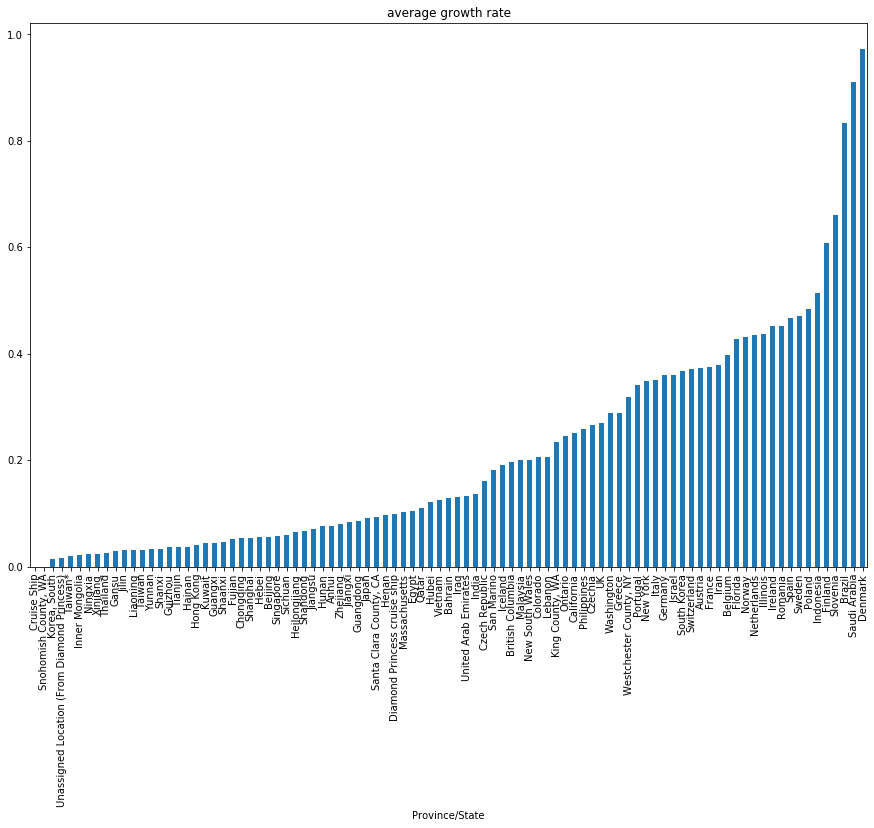

In [19]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().\
    sort_values().plot.bar(figsize=(15,10),title='average growth rate')

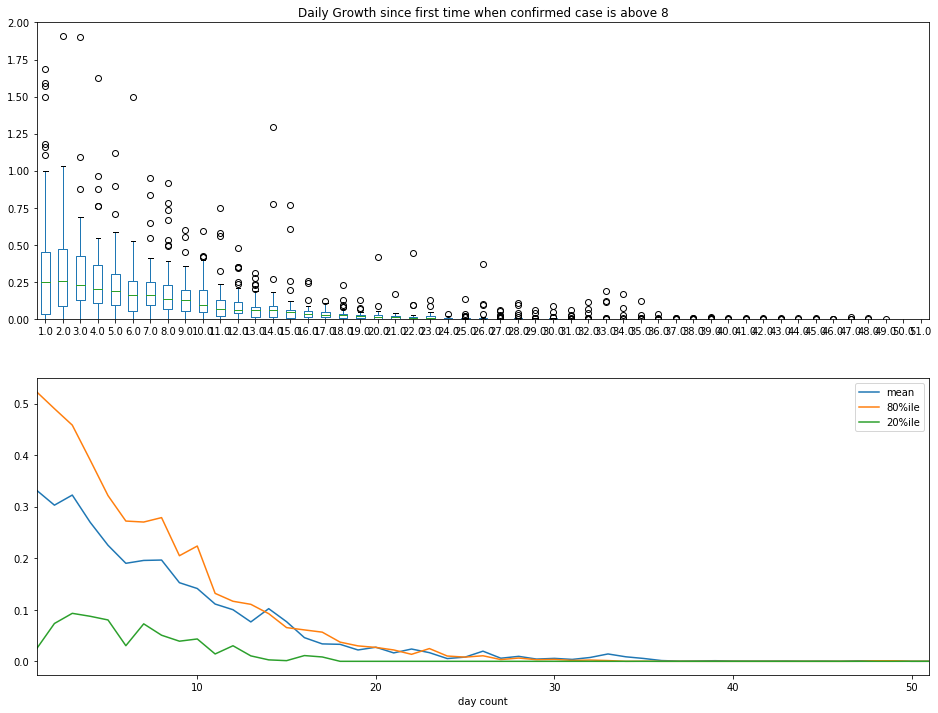

In [20]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize =(16,12))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [21]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
48,"Korea, South",7869.0
31,Hubei,444.0
88,Washington,366.0
63,Qatar,262.0
56,New York,220.0


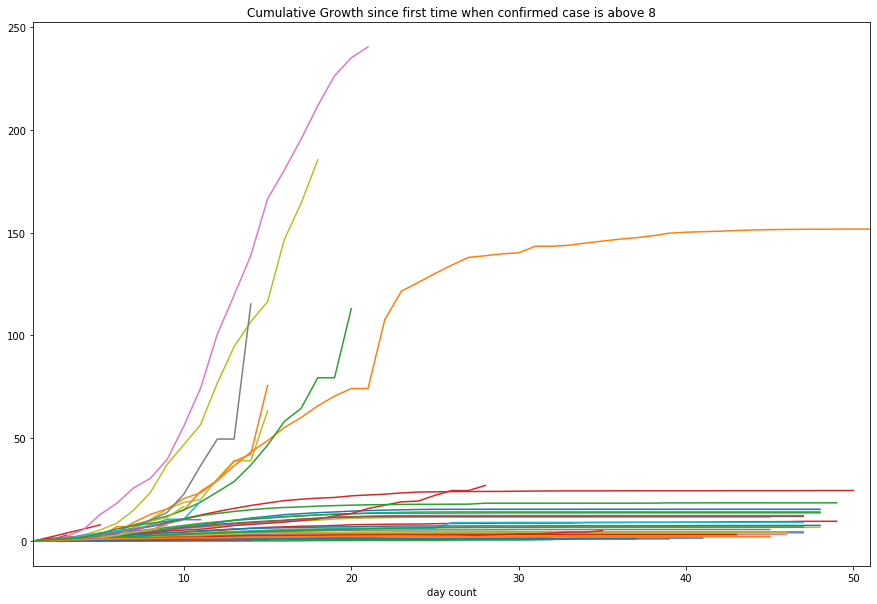

In [23]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')

cmlt_growth_df.plot.line(figsize =(15, 10), 
                         title ='Cumulative Growth since first time when confirmed case is above 8',
                         legend = False)

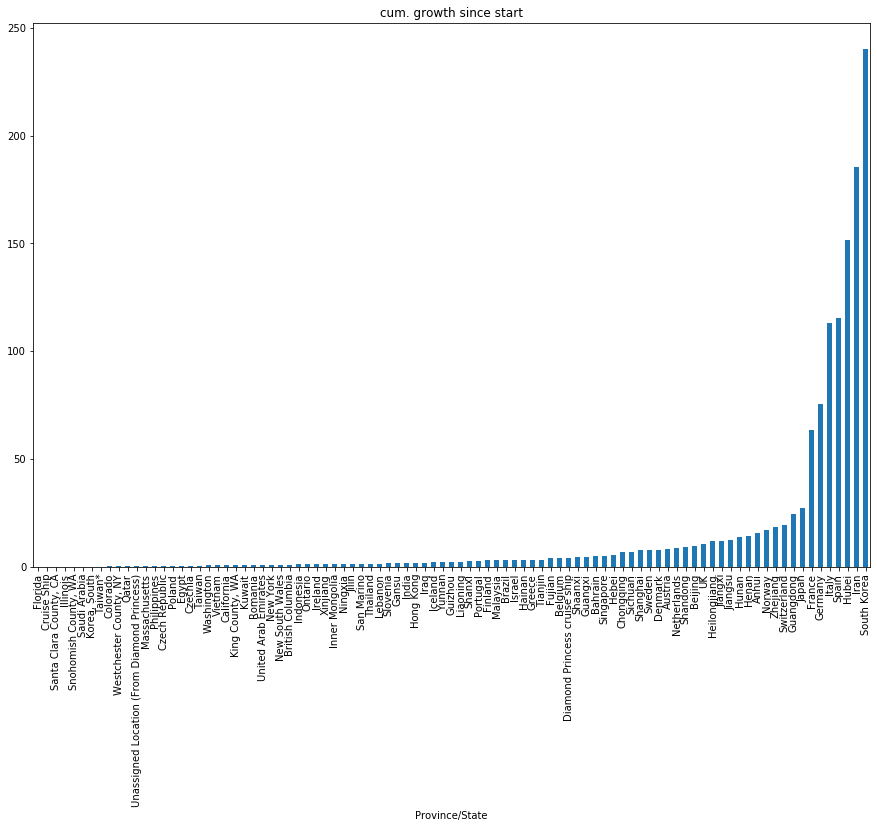

In [24]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(15,10), title='cum. growth since start')

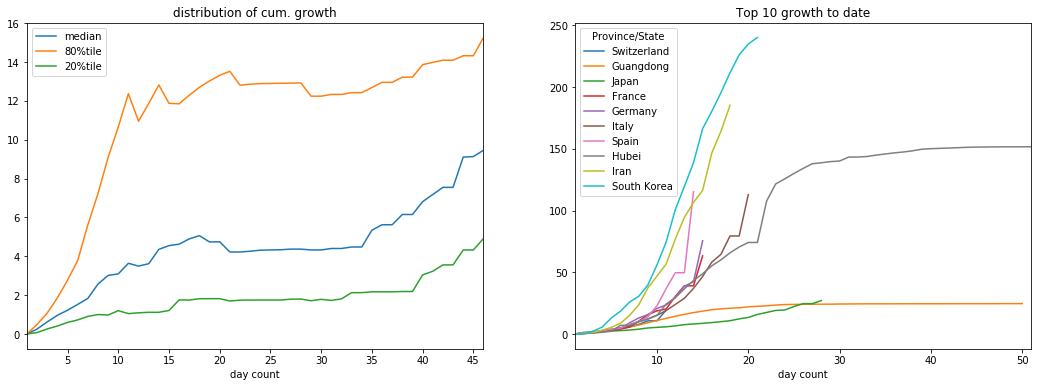

In [25]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.iloc[:-5,:].median(axis=1).plot(ax = axes[0])
cmlt_growth_df.iloc[:-5,:].quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.iloc[:-5,:].quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['median','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'Top 10 growth to date')

#### Compare China vs. Outside

In [26]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [27]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

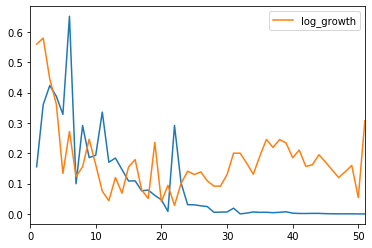

In [28]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

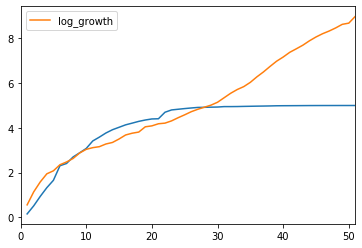

In [29]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [30]:
# The null hypothesis that the two distribution the same is reject by a simple T-test
# Looking closely, the deviation occurs after day 30. This could be due to effectivenss/ under-reporting
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=-3.0473242975190526, pvalue=0.0029534234735355625)

#### Time-series Analysis on Growth Rate

In [31]:
# auto-correlation is high in China 🇨🇳  on aggregate
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.66236801  0.68757956  0.60354235  0.49585207  0.46581302
  0.37190652  0.3506706   0.32099049  0.27515279  0.20289816  0.18824626
  0.12511141  0.06933652  0.06636514 -0.02190477  0.08663787  0.01577648
 -0.01400787 -0.01587192 -0.03815352 -0.10512136 -0.15407151 -0.17078534
 -0.18956056 -0.19545468 -0.21375703 -0.22054195 -0.22545196 -0.22797005
 -0.2121702  -0.22108922 -0.22579272 -0.22867935 -0.2329451  -0.23610393
 -0.23596287 -0.23625385 -0.23310968 -0.22590418 -0.21944268]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   51
Model:                     AutoReg(1)   Log Likelihood                  40.845
Method:               Conditional MLE   S.D. of innovations              0.107
Date:                Sun, 15 Mar 2020   AIC                             -4.352
Time:                        01:35:10   BIC                             -4.237
Sample:                             1   HQIC                            -4.308
                                   51                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0300      0.018      1.626      0.104      -0.006       0.066
log_growth.L1     0.6688      0.106      6.326      0.000       0.462       0.876
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4952           +0.0000j            1.4952            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
# auto-correlation is quite high outside of China
print(acf(outside_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is significant
model = AutoReg(outside_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.59233507  0.40766888  0.23412436  0.10855965  0.12785733
  0.08827348  0.0976337   0.00756719 -0.10309222 -0.1286971  -0.1578237
 -0.09388987 -0.05956055 -0.10413833 -0.07297332 -0.14439847 -0.11114897
 -0.14110377 -0.2334435  -0.17315936 -0.17561329 -0.0947915  -0.09957393
 -0.13716069 -0.12819082 -0.14686408 -0.11473883 -0.05490611 -0.00501702
  0.04219915 -0.03560076  0.04279349  0.02816744  0.08174823  0.14953908
  0.12512024  0.08442942  0.0649962   0.00563799 -0.01004564]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   51
Model:                     AutoReg(1)   Log Likelihood                  60.229
Method:               Conditional MLE   S.D. of innovations              0.073
Date:                Sun, 15 Mar 2020   AIC                             -5.127
Time:                        01:35:10   BIC                             -5.012
Sample:                             1   HQIC                            -5.083
                                   51                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0631      0.019      3.333      0.001       0.026       0.100
log_growth.L1     0.6074      0.092      6.628      0.000       0.428       0.787
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6464           +0.0000j            1.6464            0.0000
-----------------------------------------------------------------------------
"""

#### Predictive Models for Singapore

In [33]:
outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index()

,Country/Region,Province/State,period,Confirmed,Recovered,Deaths
0,Azerbaijan,Azerbaijan,2020-02-28,1.0,0.0,0.0
1,Afghanistan,Afghanistan,2020-02-24,1.0,0.0,0.0
2,Afghanistan,Afghanistan,2020-02-25,1.0,0.0,0.0
3,Afghanistan,Afghanistan,2020-02-26,1.0,0.0,0.0
4,Afghanistan,Afghanistan,2020-02-27,1.0,0.0,0.0
...,...,...,...,...,...,...
3674,Vietnam,Vietnam,2020-03-12,39.0,16.0,0.0
3675,Vietnam,Vietnam,2020-03-13,47.0,16.0,0.0
3676,occupied Palestinian territory,occupied Palestinian territory,2020-03-10,25.0,0.0,0.0
3677,occupied Palestinian territory,occupied Palestinian territory,2020-03-11,0.0,0.0,0.0


#### Apply econometric model given 1) small dataset and 2) preference for confidence interval

In [34]:
model_df = growth_df[growth_df.index <= growth_df[growth_df['Singapore'].isna() == False].index.max()].\
    set_index('day count')
model_df = model_df.dropna(axis=1)
model_df

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shaanxi,Shandong,Shanghai,Shanxi,Sichuan,Singapore,Tianjin,Xinjiang,Yunnan,Zhejiang
day count,,,,,,,,,,,,,,,,,,,,,
1.0,0.538462,0.138889,0.315789,0.685714,0.275000,0.656250,0.277778,0.210526,0.212121,0.454545,...,0.314286,0.630435,0.212121,0.114286,0.568182,0.100000,0.032258,0.125000,0.250000,0.441860
2.0,0.166667,0.658537,0.466667,0.355932,0.078431,0.471698,0.108696,0.260870,0.075000,0.354167,...,0.217391,0.266667,0.325000,0.205128,0.304348,0.212121,0.281250,0.083333,0.272727,0.677419
3.0,0.514286,0.176471,0.200000,0.050000,0.036364,0.423077,0.137255,0.103448,0.069767,0.261538,...,0.125000,0.368421,0.245283,0.404255,0.200000,0.125000,0.170732,0.076923,0.185714,0.230769
4.0,0.433962,0.137500,0.113636,0.202381,0.087719,0.360360,0.344828,0.109375,0.130435,0.170732,...,0.380952,0.215385,0.454545,0.121212,0.314815,0.044444,0.250000,0.071429,0.120482,0.351562
5.0,0.315789,0.219780,0.238095,0.188119,0.000000,0.370861,0.115385,0.140845,0.192308,0.083333,...,0.160920,0.164557,0.166667,0.094595,0.246479,0.063830,0.116667,0.088889,0.129032,0.710983
6.0,0.185000,0.027027,0.159341,0.200000,0.080645,0.338164,0.149425,0.098765,0.032258,0.086538,...,0.148515,0.119565,0.205357,0.000000,0.169492,0.160000,0.029851,0.122449,0.114286,0.445946
7.0,0.253165,0.219298,0.170616,0.104167,0.179104,0.277978,0.110000,0.112360,0.125000,0.115044,...,0.103448,0.116505,0.251852,0.185185,0.115942,0.155172,0.144928,0.072727,0.042735,0.257009
8.0,0.144781,0.208633,0.214575,0.125786,0.050633,0.231638,0.144144,0.101010,0.111111,0.071429,...,0.109375,0.126087,0.076923,0.083333,0.099567,0.074627,0.025316,0.067797,0.049180,0.113383
9.0,0.200000,0.136905,0.123333,0.083799,0.000000,0.227064,0.094488,0.165138,0.237500,0.162963,...,0.161972,0.061776,0.115385,0.105769,0.110236,0.041667,0.086420,0.031746,0.039062,0.103506


In [35]:
model_df.corr()['Singapore'].sort_values(ascending=False).head(10)

Province/State
Singapore         1.000000
Chongqing         0.594631
Guizhou           0.570512
Inner Mongolia    0.567974
Zhejiang          0.559232
Yunnan            0.540905
Jiangsu           0.539118
Xinjiang          0.538666
Jilin             0.534263
Beijing           0.525854
Name: Singapore, dtype: float64

In [36]:
var_model = VAR(model_df[['Singapore','Chongqing']])
results = var_model.fit(maxlags=1)
results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Mar, 2020
Time:                     01:35:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.3505
Nobs:                     34.0000    HQIC:                  -11.5280
Log likelihood:           107.050    FPE:                8.99391e-06
AIC:                     -11.6199    Det(Omega_mle):     7.59456e-06
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.032581         0.011683            2.789           0.005
L1.Singapore         0.085144         0.198834            0.428           0.668
L1.Chongqing         0.246136         0.099391            2.

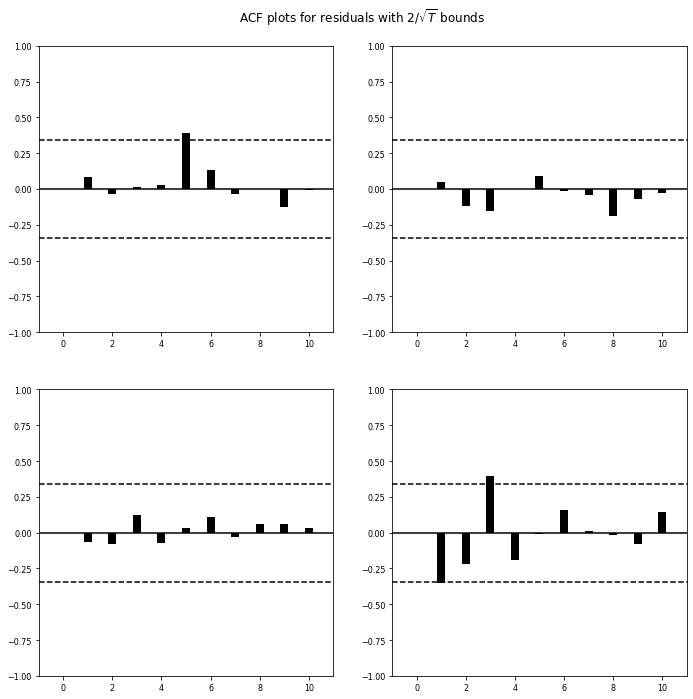

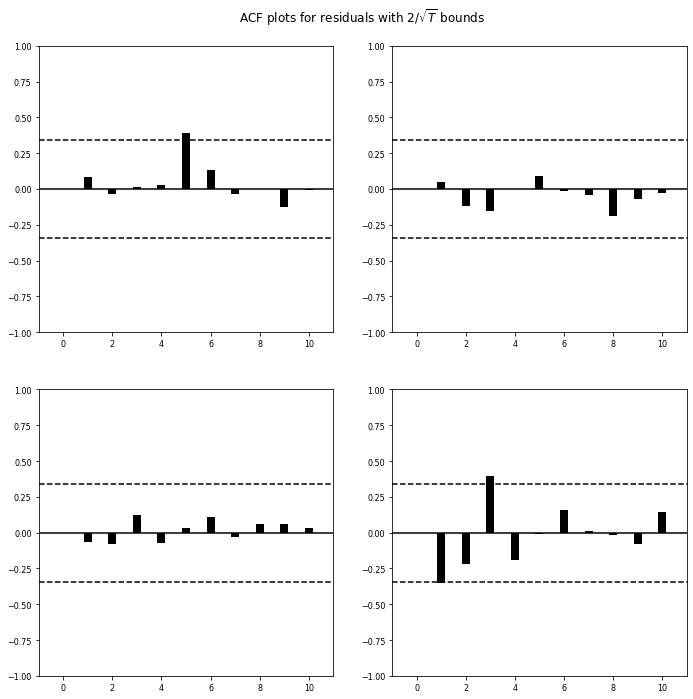

In [37]:
results.plot_acorr()

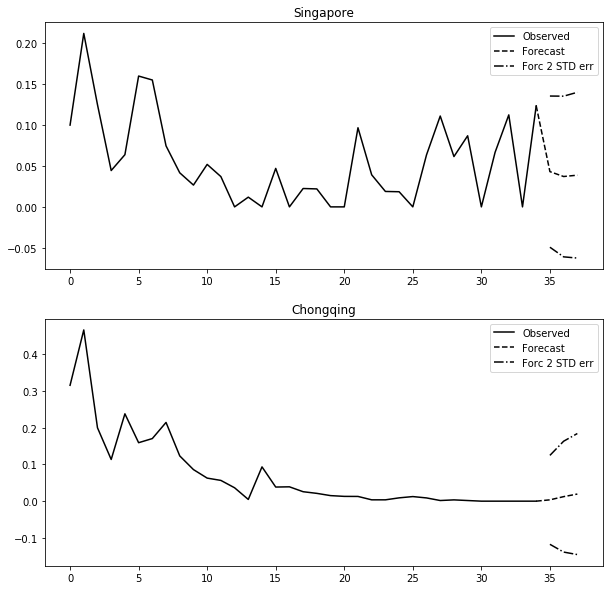

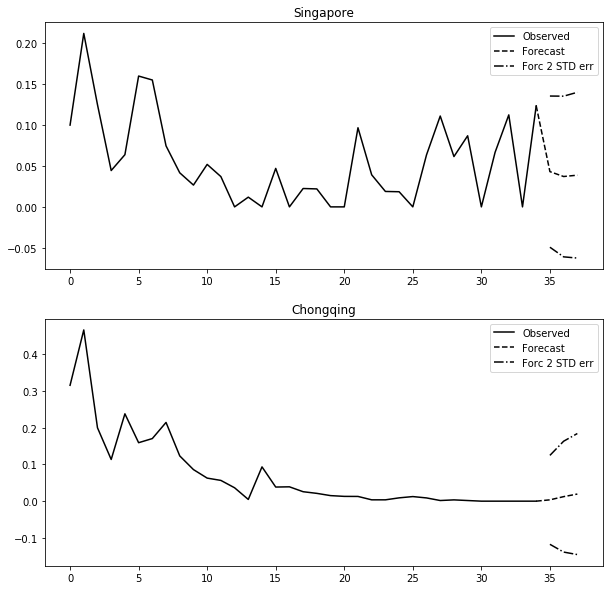

In [38]:
# Make forecast
results.plot_forecast(3)

In [39]:
# model_df[['Singapore','Hong Kong']]

# fcst_df

# fcst_df.loc[10,['Singapore','Hong Kong']].values

# np.array(fcst)

# np.array(fcst).flatten()

In [40]:
# day to be forecasted
day_forecat = model_df.index.max() + 1

In [41]:
fcst = results.forecast_interval(model_df[['Singapore','Shanghai']].values[-2:,:], 1)

In [42]:
fcst_df = heavy_affect_df[heavy_affect_df['Province/State'].isin(['Singapore','Shanghai'])].pivot(index ='day count',
                                                                                         columns = 'Province/State',
                                                                                        values = 'Confirmed')

In [43]:
fcst_num = ((np.array(fcst) + 1 ) * fcst_df.loc[day_forecat-1,['Singapore','Shanghai']].values).flatten()

In [44]:
fcst_df['Singapore_f_m'] = np.nan
fcst_df['Shanghai_f_m'] = np.nan
fcst_df['Singapore_f_lo'] = np.nan
fcst_df['Shanghai_f_lo'] = np.nan
fcst_df['Singapore_f_up'] = np.nan
fcst_df['Shanghai_f_up'] = np.nan

fcst_df.loc[day_forecat,['Singapore_f_m','Shanghai_f_m','Singapore_f_lo',
                'Shanghai_f_lo','Singapore_f_up','Shanghai_f_up']] = fcst_num

fcst_df.loc[day_forecat - 1, ['Singapore_f_m','Singapore_f_lo','Singapore_f_up']] = fcst_df.loc[day_forecat - 1,'Singapore']
fcst_df.loc[day_forecat - 1, ['Shanghai_f_m','Shanghai_f_lo','Shanghai_f_up']] = fcst_df.loc[day_forecat - 1,'Shanghai']

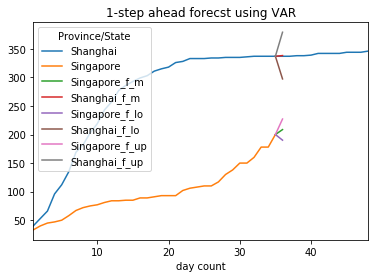

In [45]:
fcst_df.plot.line(title = '1-step ahead forecst using VAR')

### Recover rate using the latest data available

In [46]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Azerbaijan,Azerbaijan,02,28,2020-02-28 13:03:26,1.0,0.0,0.0,2020-02-28,NaN,NaN,NaN,0.000000
1,Afghanistan,Afghanistan,03,13,2020-03-11 18:00:00,7.0,0.0,0.0,2020-03-13,7.0,0.0,0.000000,0.000000
2,Albania,Albania,03,12,2020-03-12 19:39:09,23.0,0.0,1.0,2020-03-12,12.0,11.0,0.916667,0.000000
3,Algeria,Algeria,03,12,2020-03-12 07:13:24,24.0,8.0,1.0,2020-03-12,20.0,4.0,0.200000,0.333333
4,Andorra,Andorra,03,12,2020-03-12 21:44:32,1.0,1.0,0.0,2020-03-12,1.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,Vatican City,Vatican City,03,09,2020-03-06 13:43:02,1.0,0.0,0.0,2020-03-09,1.0,0.0,0.000000,0.000000
809,Vietnam,Viet Nam,03,10,2020-03-10 17:13:21,31.0,16.0,0.0,2020-03-10,NaN,NaN,NaN,0.516129
810,Vietnam,Vietnam,03,12,2020-03-12 07:33:03,39.0,16.0,0.0,2020-03-12,38.0,1.0,0.026316,0.410256
811,occupied Palestinian territory,occupied Palestinian territory,03,11,2020-03-11 18:53:02,0.0,0.0,0.0,2020-03-11,25.0,-25.0,-1.000000,NaN


Recovery over total confirmed cases: 45.04%


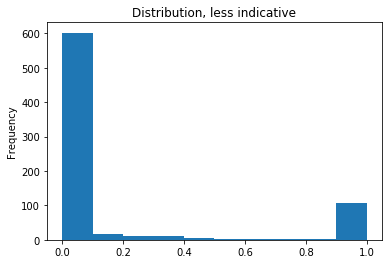

In [47]:
# Recovery rate
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Recovery over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Mortality over total confirmed cases: 3.38%


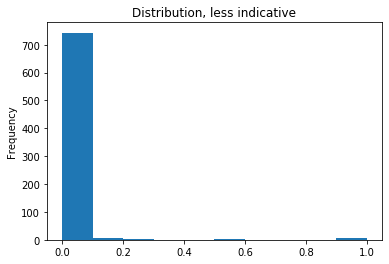

In [48]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df['mortality rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Mortality over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [49]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [50]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)